Ελευθέριος Μπόλκας 1115201900353

Τεχνικές εξόρυξης δεδομένων

Εργασία 2

Η εργασία έγινε ατομικά.

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')
m_folder="/content/gdrive/MyDrive/Colab Notebooks/erg2_data_mining/"

Για την εργασία θα χρησιμοποιηθούν 80000 γραμμές από το train dataset και 20000 γραμμές από το test dataset.

In [ ]:
import pandas as pd
import numpy as np

def createTrainTestTarget(train_f,test_f,target_f):
  df_train=pd.read_csv(train_f)
  df_test=pd.read_csv(test_f)
  df_target=pd.read_csv(target_f)

  return df_train,df_test,df_target


df_train,df_test,df_target=createTrainTestTarget(m_folder+"train.csv",m_folder+"test.csv",m_folder+"target.csv")

df_train=df_train.iloc[:80000,:]
df_test=df_test.iloc[:20000,:]
df_target=df_target.iloc[:20000,:]

#print(df_train)
#print(df_test)
#print(df_target)



#Ανάλυση Δεδομένων

#1)

Αρχικά χρησιμοποιώντας την describe τυπώνουμε κάποια στατιστικά για τα δεδομένα του train set.

In [ ]:
print(df_train.describe())

          vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  80000.000000     80000.000000      80000.000000     80000.000000   
mean       1.533575         1.656713        -73.973548        40.750995   
std        0.498875         1.303414          0.039935         0.029431   
min        1.000000         0.000000        -75.238327        39.923027   
25%        1.000000         1.000000        -73.991814        40.737293   
50%        2.000000         1.000000        -73.981834        40.754074   
75%        2.000000         2.000000        -73.967377        40.768353   
max        2.000000         6.000000        -70.851616        43.017578   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       80000.000000      80000.000000   80000.000000  
mean          -73.973426         40.752015     933.034963  
std             0.037912          0.033554    2941.547355  
min           -74.705360         40.271030       1.000000  
25%           -73.991302

Αφαιρούμε τώρα τα outliers και ξανατυπώνουμε τα στατιστικά στα νέα δεδομένα.

In [ ]:
#Calculate mean and standard deviation
mean_train=df_train["trip_duration"].mean()
std_train=df_train["trip_duration"].std()

#Remove outliers
df_train=df_train.drop(df_train[(df_train["trip_duration"]<mean_train-2*std_train) | (df_train["trip_duration"]>mean_train+2*std_train)].index)
df_train=df_train.reset_index(drop=True)

print(df_train.describe())

          vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  79894.000000     79894.000000      79894.000000     79894.000000   
mean       1.532994         1.656407        -73.973537        40.751018   
std        0.498913         1.303058          0.039664         0.029278   
min        1.000000         0.000000        -74.705368        40.276291   
25%        1.000000         1.000000        -73.991812        40.737309   
50%        2.000000         1.000000        -73.981827        40.754089   
75%        2.000000         2.000000        -73.967371        40.768360   
max        2.000000         6.000000        -70.851616        43.017578   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       79894.000000      79894.000000   79894.000000  
mean          -73.973424         40.752016     832.719190  
std             0.037916          0.033551     648.195758  
min           -74.705360         40.271030       1.000000  
25%           -73.991302

Παρατηρούμε ότι αφαιρέθηκαν 106 διαδρομές. Σημαντικές διαφορές στα στατιστικά υπήρξαν μόνο στη στήλη trip_duration.

# 2)

Εδώ αφαιρούμε όλες τις γραμμές που έχουν σημεία εκτός της πόλης της Νέας Υόρκης.

In [ ]:
def clear_out_NY(df,df_target=None):
  pickup_out_indices=df[(df["pickup_longitude"]<-74.03) | 
                        (df["pickup_longitude"]>-73.75) |
                        (df["pickup_latitude"]<40.63) | 
                        (df["pickup_latitude"]>40.85)
                        ].index

  dropoff_out_indices=df[(df["dropoff_longitude"]<-74.03) | 
                         (df["dropoff_longitude"]>-73.75) |
                         (df["dropoff_latitude"]<40.63) | 
                        (df["dropoff_latitude"]>40.85)
                       ].index

  all_out_indices=pickup_out_indices.union(dropoff_out_indices)

  df=df.drop(all_out_indices)
  df=df.reset_index(drop=True)

  if df_target is not None:
    df_target=df_target.drop(all_out_indices)
    df_target=df_target.reset_index(drop=True)

  return df,df_target

df_train=clear_out_NY(df_train)[0]
df_test,df_target=clear_out_NY(df_test,df_target)

dropoff_out_indices=df_train[(df_train["dropoff_longitude"]<-74.03) | 
                         (df_train["dropoff_longitude"]>-73.75) |
                         (df_train["dropoff_latitude"]<40.63) | 
                        (df_train["dropoff_latitude"]>40.85)
                       ].index

#print(df_train.shape) 
#print(df_test.shape) 
#print(df_target.shape) 


# 3)

Μετατρέπουμε τώρα τις στήλες datetime σε μία πιο εύχρηστη μορφή και στη συνέχεια τις διασπάμε στις στήλες day_period, day_name, month, hour, year, season.

In [ ]:
#Return day period based on the time
def get_day_period(hour):
  if hour>=6 and hour<12:
    return "Morning"
  elif hour>=12 and hour<16:
    return "Afternoon"
  elif hour>=16 and hour<22:
    return "Evening"
  else:
    return "Late night"

#Return season name based on the month
def get_season(month):
  if month>=3 and month<6:
    return "Spring"
  elif month>=6 and month<9:
    return "Summer"
  elif month>=9 and month<12:
    return "Autumn"
  else:
    return "Winter"

def convert_daytime(df):
  for str in ["pickup_","dropoff_"]:
    #In test dataframe ignore dropoff datetime
    if str=="pickup_" or ("dropoff_datetime" in df.columns):
      df[str+"day_period"]=df[str+"datetime"].dt.hour.apply(get_day_period)
      df[str+"day_name"]=df[str+"datetime"].dt.day_name()
      df[str+"month"]=df[str+"datetime"].dt.month_name()
      df[str+"hour"]=df[str+"datetime"].dt.hour
      df[str+"year"]=df[str+"datetime"].dt.year
      df[str+"season"]=df[str+"datetime"].dt.month.apply(get_season)


df_train["pickup_datetime"]=pd.to_datetime(df_train["pickup_datetime"])
df_train["dropoff_datetime"]=pd.to_datetime(df_train["dropoff_datetime"])

df_test["pickup_datetime"]=pd.to_datetime(df_test["pickup_datetime"])

convert_daytime(df_train)
convert_daytime(df_test)

#display(df_train)
#display(df_test)

Φτιάχνουμε τώρα τον κώδικα για τη σχεδίαση των ιστογραμμάτων.

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 8]

#Plot a histogram by grouping the elements of a column
def plot_hist(df,column,colour,name,sort_key=None):
    copyDf=df.copy()
    if sort_key==None:
      copyDf=copyDf.groupby(
        [copyDf[column].rename(column)],sort=False
        ).size().sort_values(ascending=False).plot(kind="bar",color=colour)
    else:
      copyDf=copyDf.groupby(
        [copyDf[column].rename(column)],sort=False
        ).size().sort_index(key=sort_key).plot(kind="bar",color=colour)
    plt.title(name)
    plt.tight_layout()
    plt.show()

#Plot a histogram by grouping the elements of a column and calculating the average trip duration for each group
def plot_hist_trip_duration(df,column,colour,name,sort_key=None):
    copyDf=df.copy()
    copyDf=copyDf.groupby(
        [copyDf[column].rename(column)],sort=False
        )["trip_duration"].mean().sort_index(key=sort_key).plot(kind="bar",color=colour)
    plt.title(name)
    plt.tight_layout()
    plt.show()

Παρακάτω φαίνεται το ιστόγραμμα για τις πιο πολυσύχναστες pickup days ταξινομημένες από τις πιο πολυσύχναστες στις λιγότερο πολυσύχναστες. Όπως βλέπουμε, τις μέρες Πέμπτη, Παρασκευή και Σάββατο ξεκίνησαν οι περισσότερες διαδρομές.

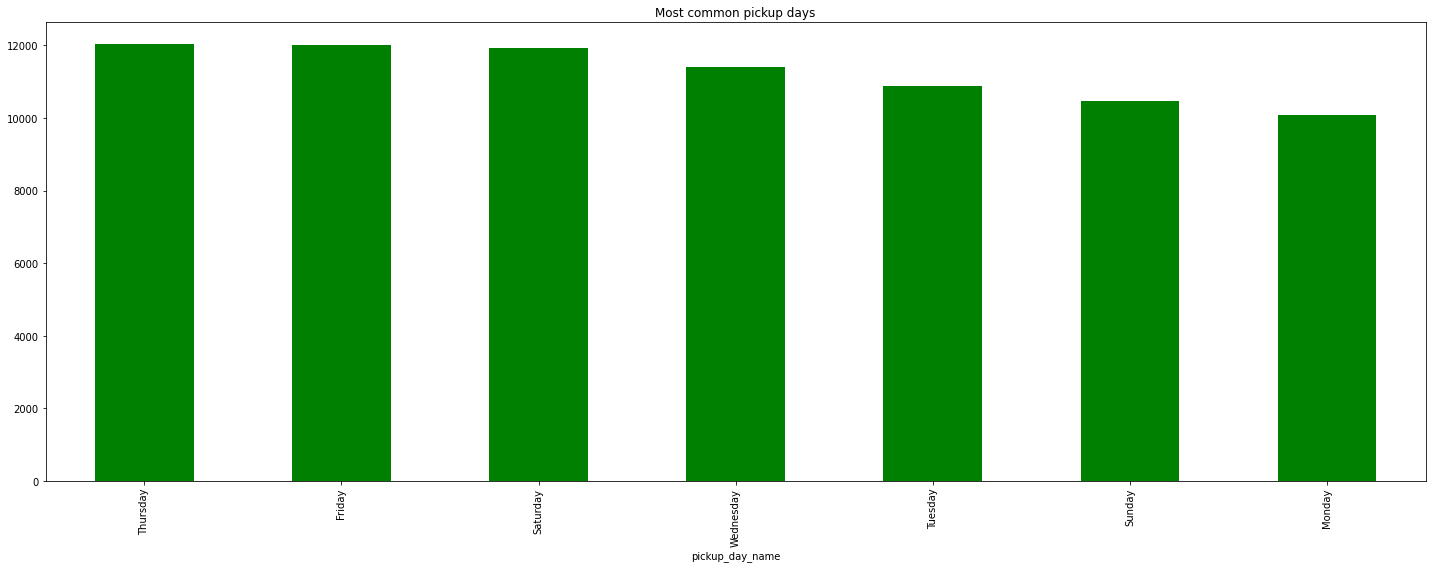

In [ ]:
plot_hist(df_train,"pickup_day_name","green","Most common pickup days")

Εδώ φαίνεται το ιστόγραμμα για τις πιο πολυσύχναστες dropoff days ταξινομημένες από τις πιο πολυσύχναστες στις λιγότερο πολυσύχναστες. Όπως βλέπουμε και εδώ, τις μέρες Πέμπτη, Παρασκευή και Σάββατο τελείωσαν οι περισσότερες διαδρομές.

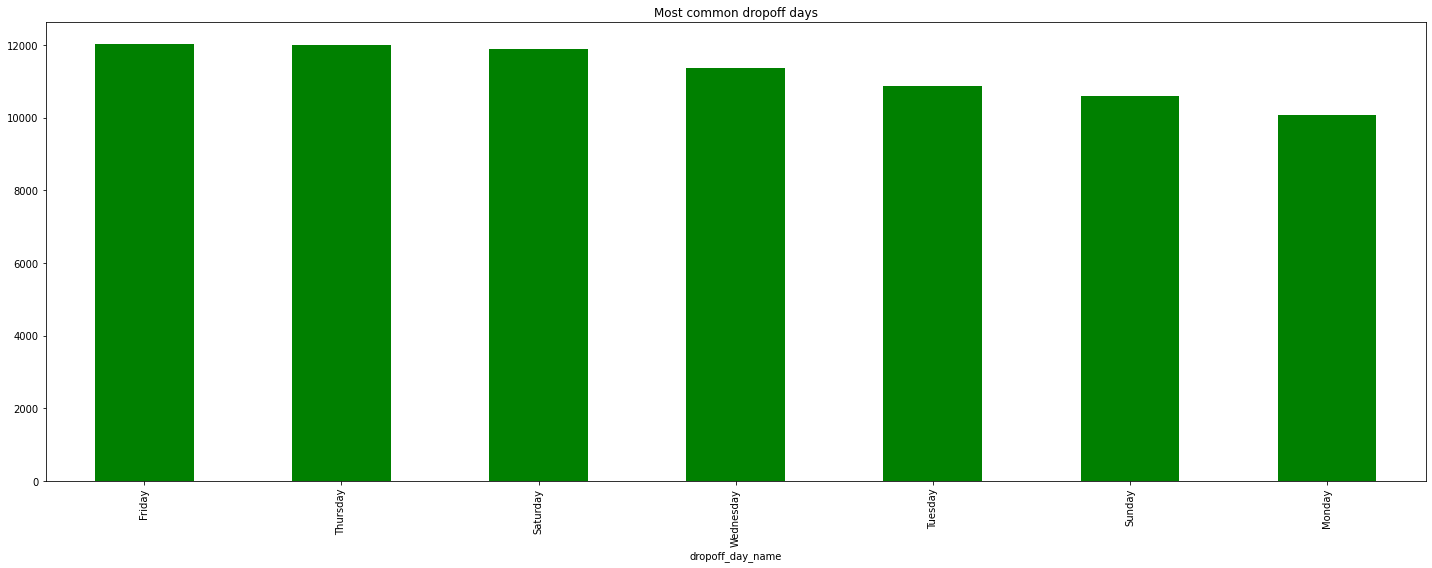

In [ ]:
plot_hist(df_train,"dropoff_day_name","green","Most common dropoff days")

Παρακάτω φαίνεται ο αριθμός των Trips ανά pickup_day_period. Παρατηρούμε ότι με μεγάλη διαφορά οι περισσότερες διαδρομές ξεκίνησαν κατά το evening.


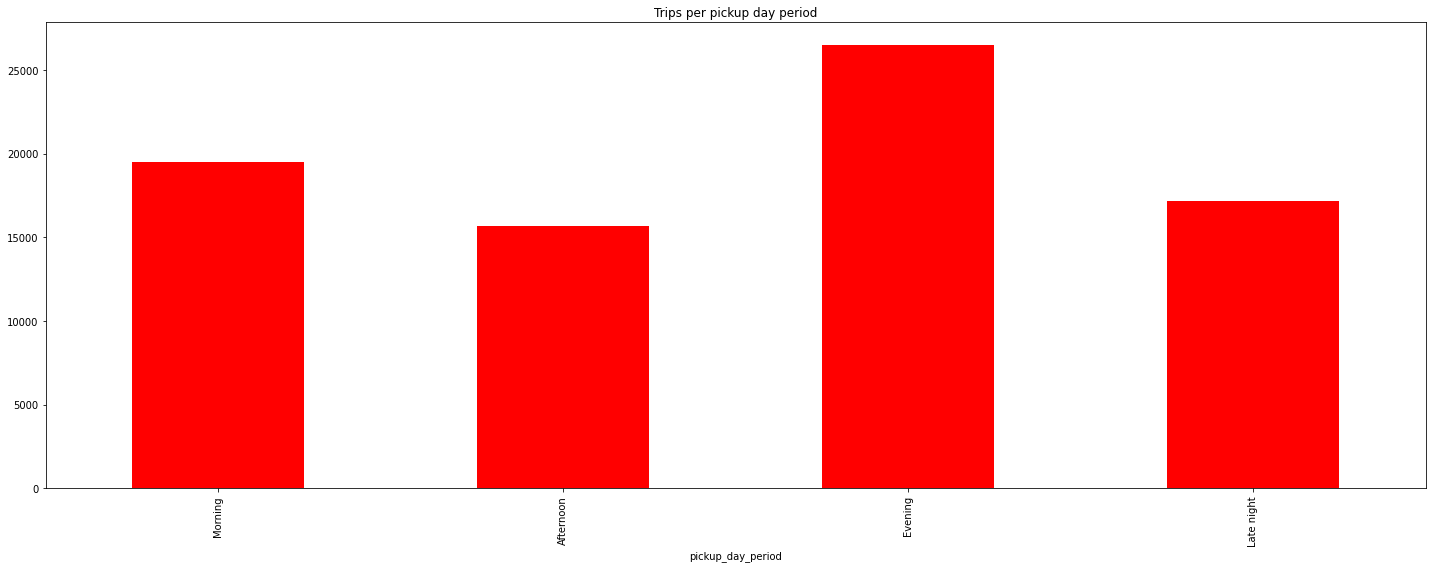

In [ ]:
day_dict={'Morning': 0, 
          'Afternoon': 1, 
          'Evening': 2, 
          'Late night': 3, 
}

plot_hist(df_train,"pickup_day_period","red","Trips per pickup day period",sort_key=lambda x: x.map(day_dict))


Εδώ φαίνεται ο αριθμός των Trips ανά pickup_dropoff_period. Και εδώ οι περισσότερες διαδρομές τελειώνουν κατά το evening.



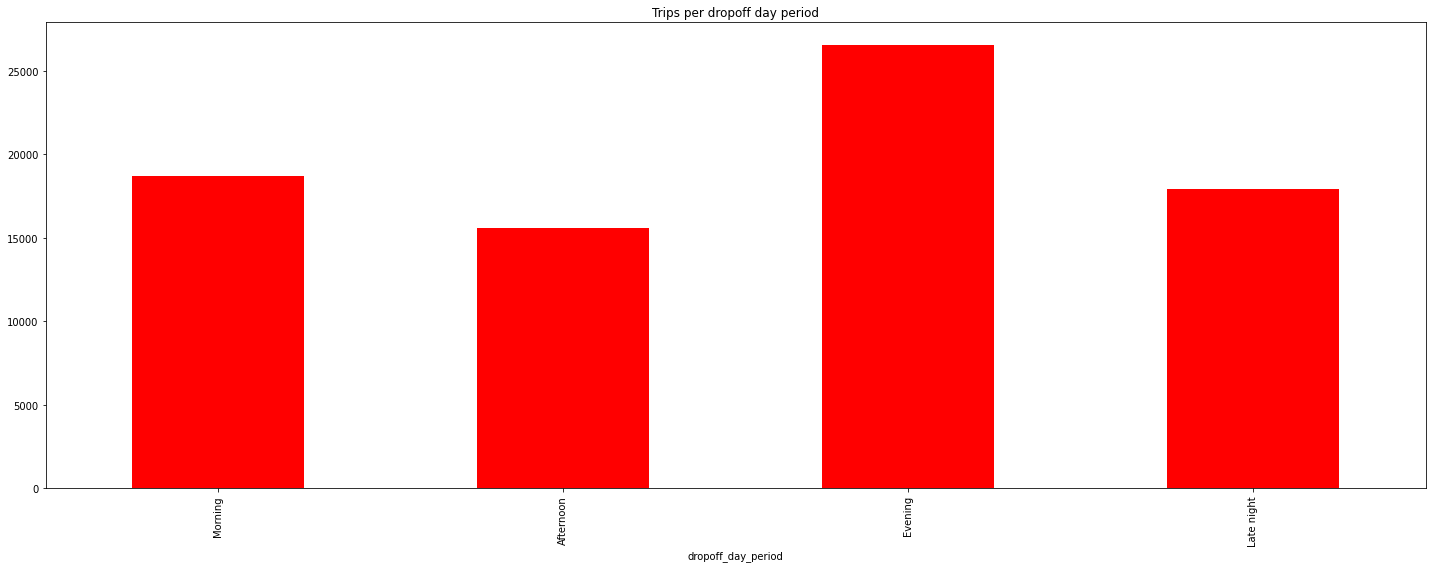

In [ ]:
plot_hist(df_train,"dropoff_day_period","red","Trips per dropoff day period",sort_key=lambda x: x.map(day_dict))

Παρακάτω φαίνεται ο αριθμός των Trips ανά pickup_month. Διαπιστώνουμε ότι οι περισσότερες διαδρομές ξεκινούν κατά τους ανοιξιάτικους μήνες.



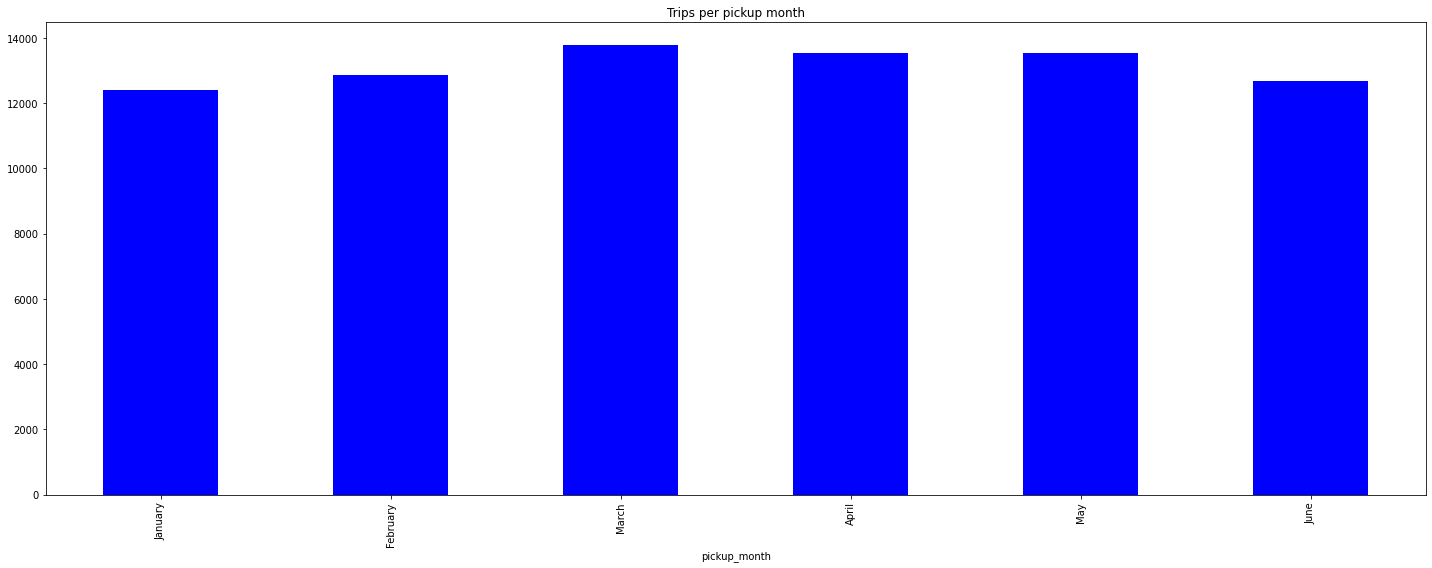

In [ ]:
month_dict={"January":1,
       "February":2,
       "March":3,
       "April":4,
       "May":5,
       "June":6,
       "July":7,
       "August":8,
       "September":9,
       "October":10,
       "November":11,
       "December":12
}

plot_hist(df_train,"pickup_month","blue","Trips per pickup month",sort_key=lambda x: x.map(month_dict))

Εδώ φαίνεται ο αριθμός των Trips ανά dropoff_month. Κι εδώ διαπιστώνουμε ότι οι περισσότερες διαδρομές τελειώνουν κατά τους ανοιξιάτικους μήνες.

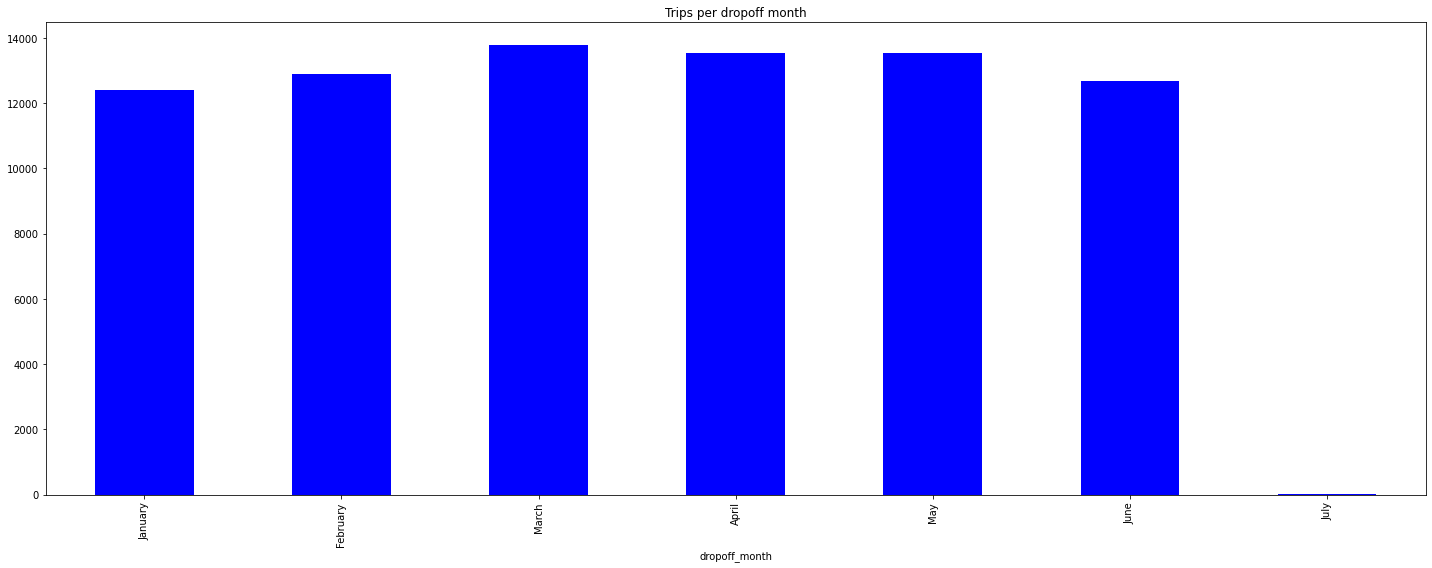

In [ ]:
plot_hist(df_train,"dropoff_month","blue","Trips per dropoff month",sort_key=lambda x: x.map(month_dict))

Εδώ φαίνεται η μέση διάρκεια ταξιδιού ανά pickup_hour. Τις μεσημεριανές ώρες παρατηρούμε ότι οι διαδρομές είναι μεγαλύτερες σε διάρκεια, το οποίο θα ανέμενε άλλωστε κανείς καθώς εκείνες τις ώρες γνωρίσουμε ότι η κίνηση είναι αυξημένη.

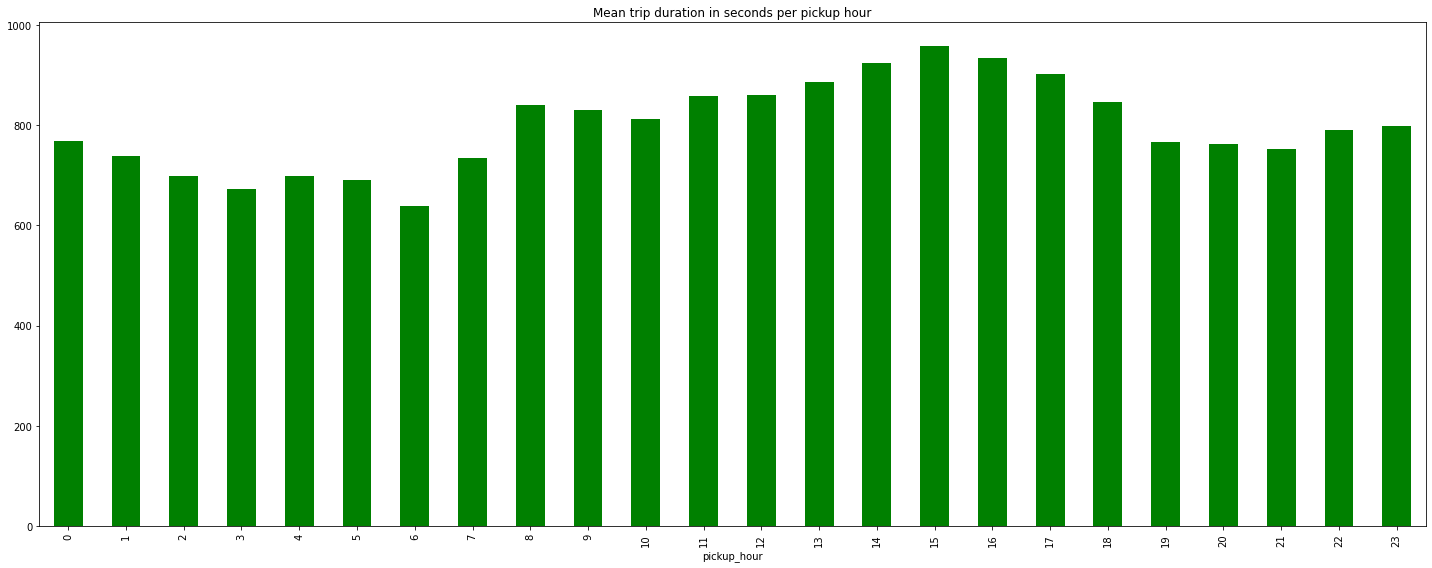

In [ ]:
plot_hist_trip_duration(df_train,"pickup_hour","green","Mean trip duration in seconds per pickup hour")

Παρακάτω φαίνεται η μέση διάρκεια ταξιδιού ανά pickup_day_period. Αντίστοιχα και για τους ίδιους λόγους με τις ώρες παραπάνω, το afternoon παρατηρούμε ότι οι διαδρομές είναι μεγαλύτερες σε διάρκεια κατά μέσο όρο.

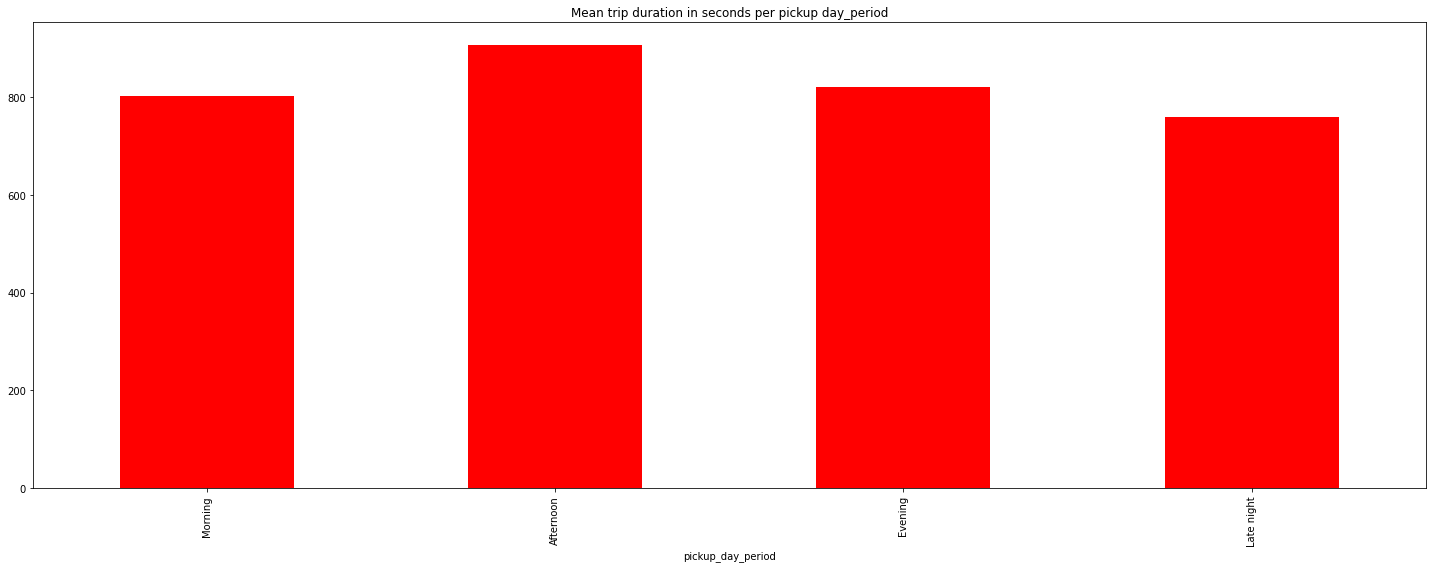

In [ ]:
plot_hist_trip_duration(df_train,"pickup_day_period","red","Mean trip duration in seconds per pickup day_period",sort_key=lambda x: x.map(day_dict))

Εδώ φαίνεται η μέση διάρκεια ταξιδιού ανά μέρα της εβδομάδας. Όπως βλέπουμε, τις καθημερινές(εκτός της Δευτέρας) η διάρκεια ταξιδιού είναι αυξημένη, πιθανώς λόγω των πολλών ατόμων που εργάζονται.

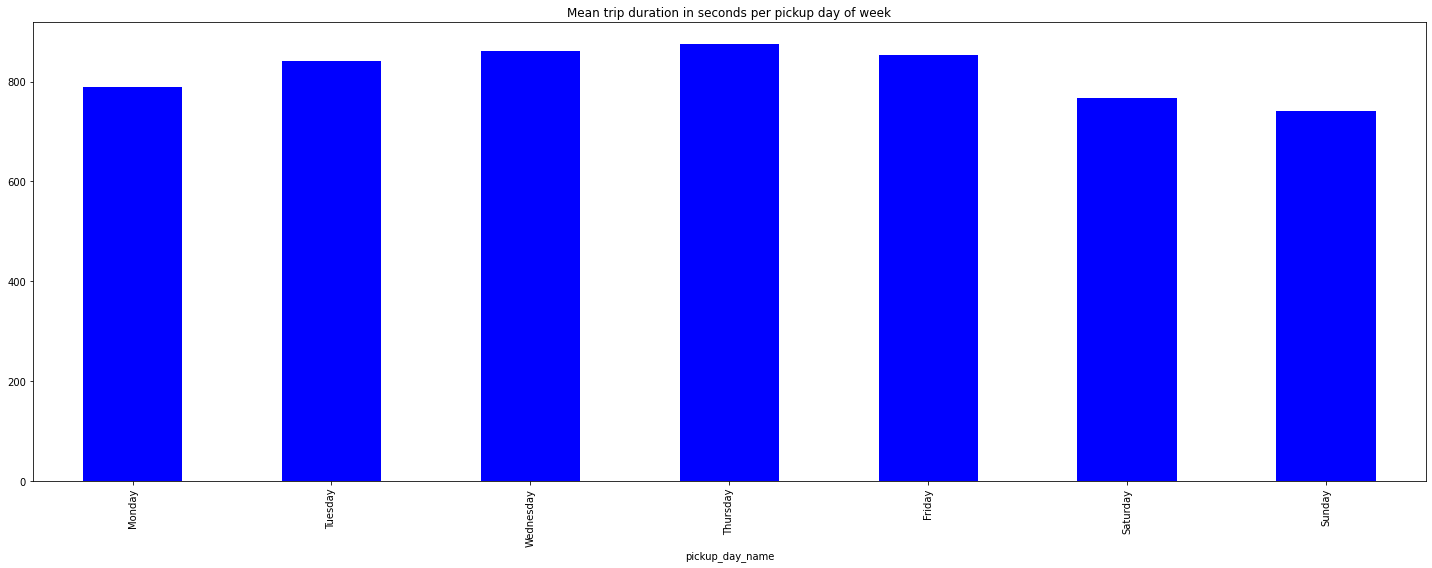

In [ ]:
day_of_week_dict={'Monday': 0, 
                  'Tuesday': 1, 
                  'Wednesday': 2, 
                  'Thursday': 3, 
                  'Friday': 4, 
                  'Saturday': 5, 
                  'Sunday': 6}

plot_hist_trip_duration(df_train,"pickup_day_name","blue","Mean trip duration in seconds per pickup day of week",sort_key=lambda x: x.map(day_of_week_dict))

# 4)

Παρακάτω σχεδιάζουμε ένα ιστόγραμμα για τη διάρκεια του ταξιδιού χωρισμένη σε 100 κάδους.

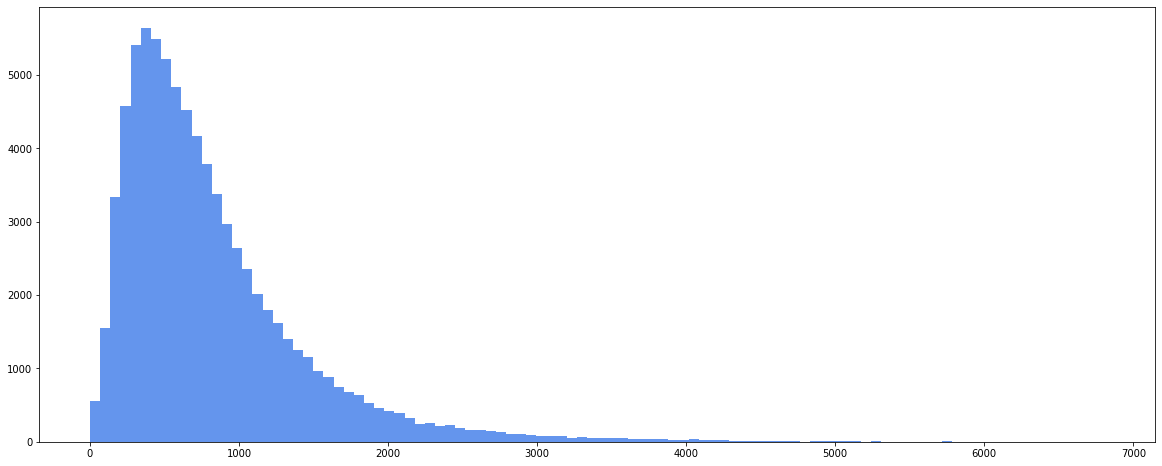

In [ ]:
plt.hist(df_train["trip_duration"], bins = 100,color="cornflowerblue")
plt.show()

#α), β)

Εφαρμόζουμε τώρα log transformation στη διάρκεια του ταξιδιού, προσθέτοντας το αποτέλεσμα ως νέα στήλη στο dataframe και σχεδιάζουμε το αντίστοιχο ιστόγραμμα για το αποτέλεσμα. Παρατηρούμε ότι το νέο ιστόγραμμα παρουσιάζει καλύτερα τα δεδομένα.

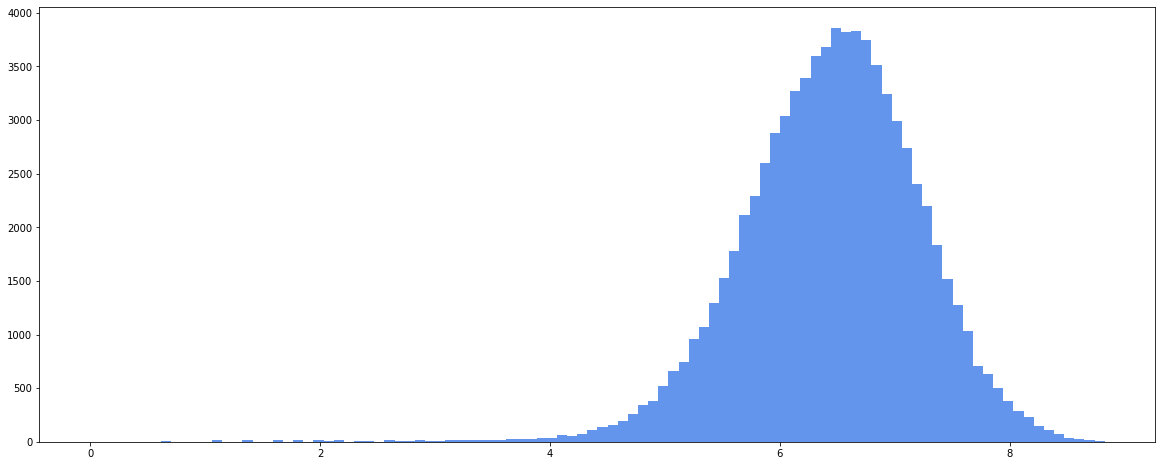

In [ ]:
df_train["log_trip_duration"]=np.log(df_train["trip_duration"])
plt.hist(df_train["log_trip_duration"], bins = 100,color="cornflowerblue")
plt.show()

# 5)

Εδώ φτιάχνουμε ένα ιστόγραμμα που παρουσιάζει τη μέση διάρκεια ταξιδιού ανά πάροχο.

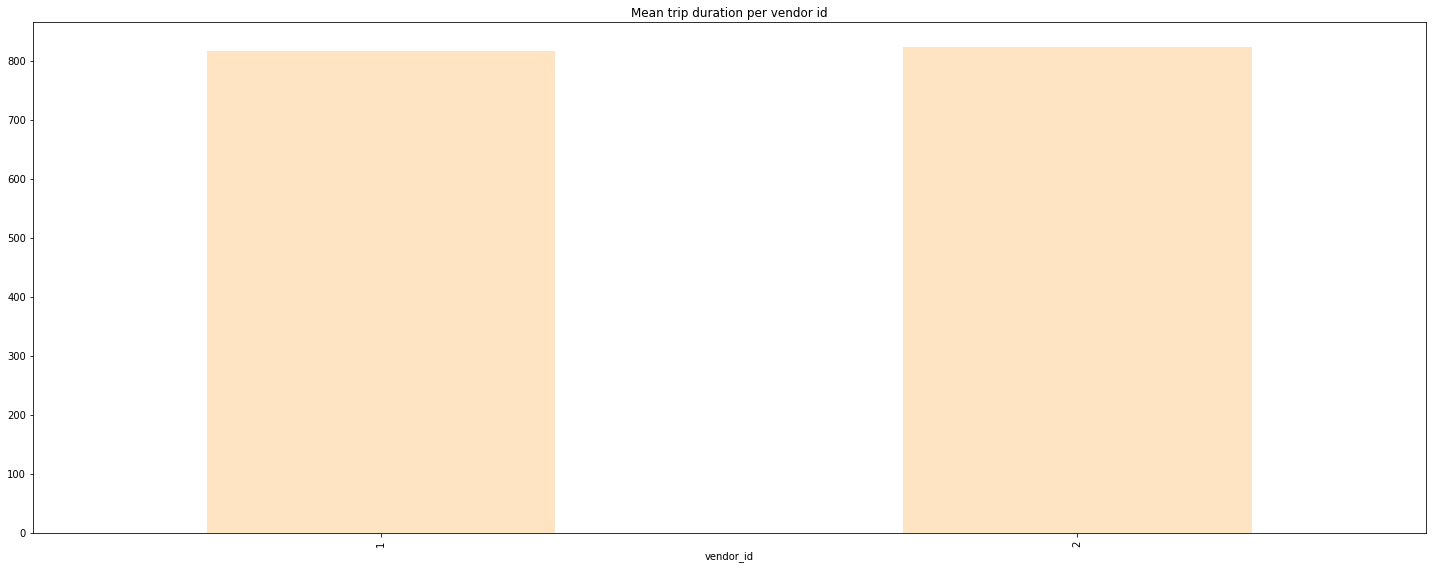

In [ ]:
plot_hist_trip_duration(df_train,"vendor_id","bisque","Mean trip duration per vendor id")

# 6)
Τώρα, θα εξετάσουμε πόση επίδραση έχει ο αριθμός των επιβατών στη διάρκεια ταξιδιού. Για το σκοπό αυτό θα σχεδιάσουμε ένα ιστόγραμμα που δείχνει τη μέση διάρκεια ταξιδιού ανά αριθμό επιβατών.

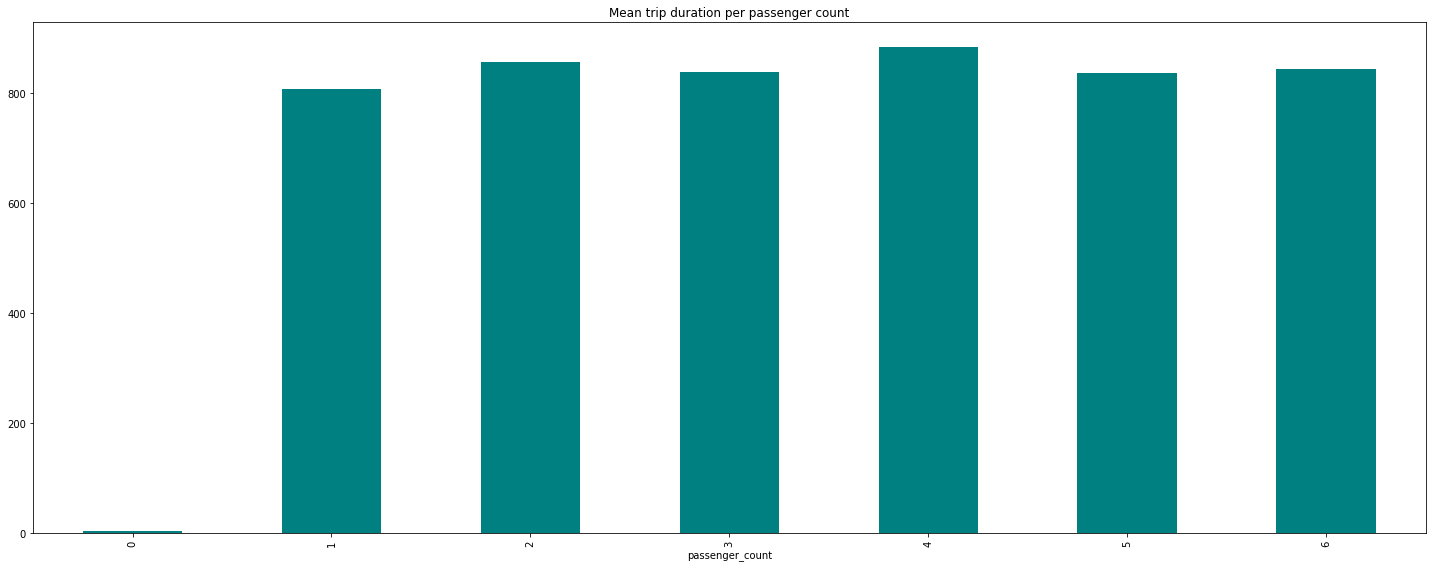

In [ ]:
plot_hist_trip_duration(df_train,"passenger_count","teal","Mean trip duration per passenger count")

Βλέπουμε ότι η διαφορά στο χρόνο ταξιδιού ανά αριθμό επιβατών είναι μικρή και δεν θεωρείται σημαντική. Άρα, ο αριθμός επιβατών δεν επηρρεάζει ιδιαίτερα το χρόνο της διαδρομής.

# 7)

Προσθέτουμε τώρα μια στήλη στα δεδομένα μας με την απόσταση Manhattan μεταξύ αφετηρίας και προορισμού.

In [ ]:
from sklearn.metrics.pairwise import manhattan_distances

def calcManhDist(df):
  pickPoints=df[["pickup_longitude","pickup_latitude"]].to_numpy()
  dropPoints=df[["dropoff_longitude","dropoff_latitude"]].to_numpy()
  df["manhattan_distance"]=np.sum(abs(pickPoints-dropPoints),axis=1)

calcManhDist(df_train)
calcManhDist(df_test)



Παρακάτω σχεδιάζεται το ιστόγραμμα με τη μέση απόσταση των διαδρομών ανά μέρα της εβδομάδας. Όπως παρατηρούμε η μέση απόσταση των διαδρομών είναι παρόμοια όλες τις μέρες με εξαίρεση την Κυριακή που είναι λίγο μεγαλύτερη. Αυτό μπορεί να οφείλεται στο ότι τις Κυριακές γίνονται περισσότερες διαδρομές για λόγους αναψυχής σε σχέση με τις διαδρομές για λόγους εργασίας.

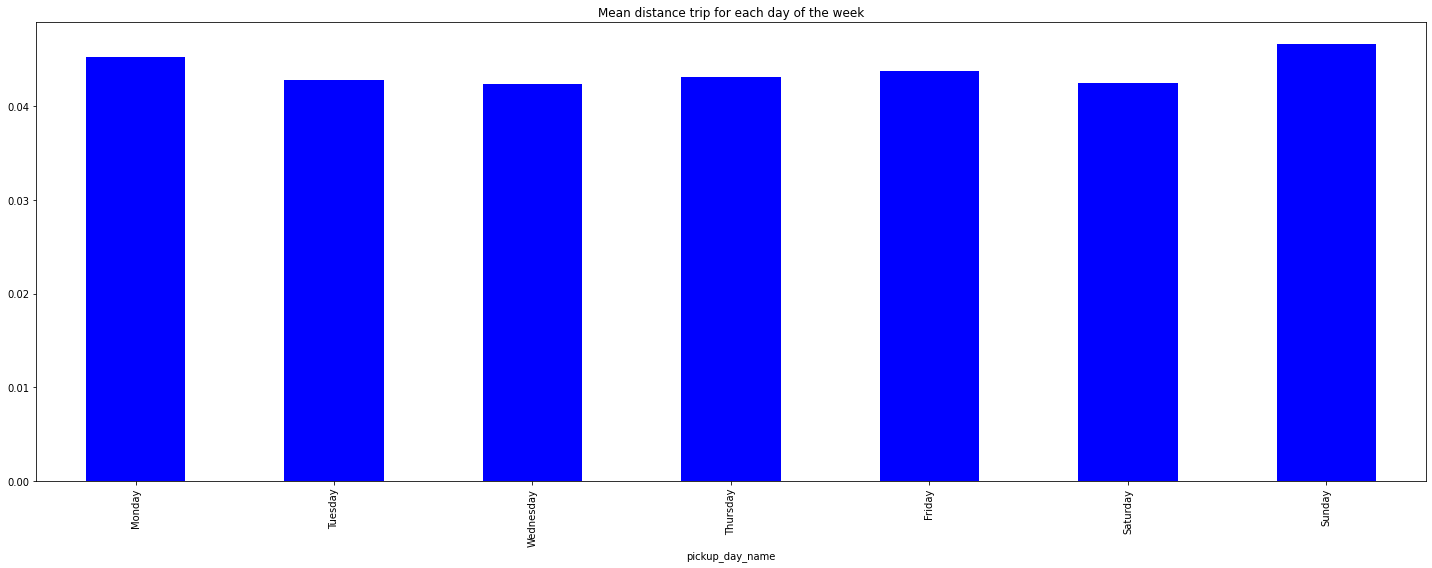

In [ ]:
#Plot an histogram by grouping a column and calculating the average manhattan distance for each group
def plot_hist_dist(df,column,colour,name,sort_key=None):
    copyDf=df.copy()
    copyDf=copyDf.groupby(
        [copyDf[column].rename(column)],sort=False
        )["manhattan_distance"].mean().sort_index(key=sort_key).plot(kind="bar",color=colour)
    plt.title(name)
    plt.tight_layout()
    plt.show()

plot_hist_dist(df_train,"pickup_day_name","blue","Mean distance trip for each day of the week",sort_key=lambda x: x.map(day_of_week_dict))

Τώρα σχεδιάζουμε ένα διάγραμμα που δείχνει το χρόνο της διαδρομής σε συνάρτηση με την απόσταση. Συγκεκριμένα κάθε μπάρα του διαγράμματος δείχνει για την απόσταση του συγκεκριμένου του ταξιδιού, πόση χρονική διάρκεια διήρκησε η αντίστοιχη διαδρομή. Χρησιμοποιούνται 10000 διαδρομές για πιο ευκρινή αποτελέσματα.

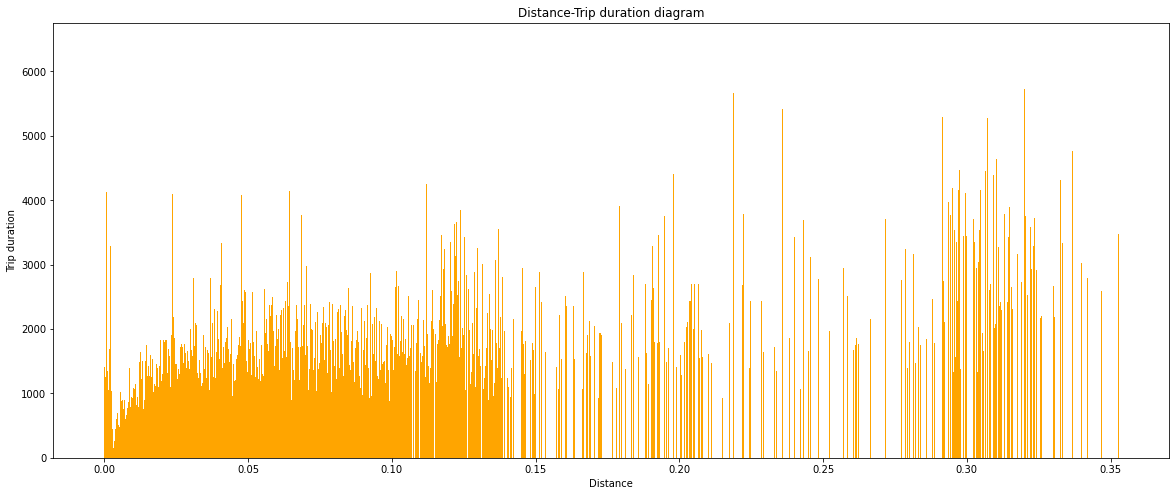

In [ ]:
def plotTimeDist(df):
    plt.title("Distance-Trip duration diagram")
    plt.xlabel("Distance")
    plt.ylabel("Trip duration")
    copyDf=df.copy()
    copyDf=copyDf.iloc[:10000,:] #Do not draw more than that, since this creates problems
    copyDf=copyDf.drop(copyDf[(copyDf["manhattan_distance"]>0.5)].index) #Ignore huge distances
    plt.bar(copyDf["manhattan_distance"].to_numpy(),copyDf["trip_duration"].to_numpy(),color="orange",width=0.0002)
    plt.show()

plotTimeDist(df_train)

Παρατηρούμε, όπως είναι λογικό, ότι για τις περισσότερες διαδρομές(χωρίς όμως να ισχύει πάντα) όσο μεγαλύτερη είναι η απόσταση Manhattan μιας διαδρομής τόσο περισσότερος είναι ο χρόνο του ταξιδιού.

# 8)

Θα προσθέσουμε τώρα σε ένα προσωρινό αντίγραφο του dataframe μία στήλη με τη μέση ταχύτητα ανά διαδρομή. Αξιοποιώντας αυτή τη στήλη θα φτιάξουμε τα ζητούμενα γραφήματα χρησιμοποιώντας τη σχετική συνάρτηση στον παρακάτω κώδικα.

In [ ]:
tempDf=df_train.copy()
tempDf["avg_speed"]=tempDf["manhattan_distance"]/tempDf["trip_duration"]

#Plot an histogram by grouping a column and calculating the average speed distance for each group
def plot_hist_avg_speed(df,column,colour,name,sort_key=None):
    copyDf=df.copy()
    copyDf=copyDf.groupby(
        [copyDf[column].rename(column)],sort=False
        )["avg_speed"].mean().sort_index(key=sort_key).plot(kind="bar",color=colour)
    plt.title(name)
    plt.tight_layout()
    plt.show()

Παρακάτω παρουσιάζεται ένα ιστόγραμμα με τη μέση ταχύτητα των διαδρομών ανά ώρα της εβδομάδας. Όπως βλέπουμε κατά τις νυχτερινές ώρες η μέση ταχύτητα είναι πολύ μεγαλύτερη από τις υπόλοιπες ώρες. Από αυτό θα μπορούσαμε πιθανώς να συμπεράνουμε, όπως άλλωστε είναι λογικό, ότι η κυκλοφοριακή συμφόρηση τις ώρες της ημέρας είναι είναι πολύ μεγαλύτερη από τις νυχτερινές ώρες.



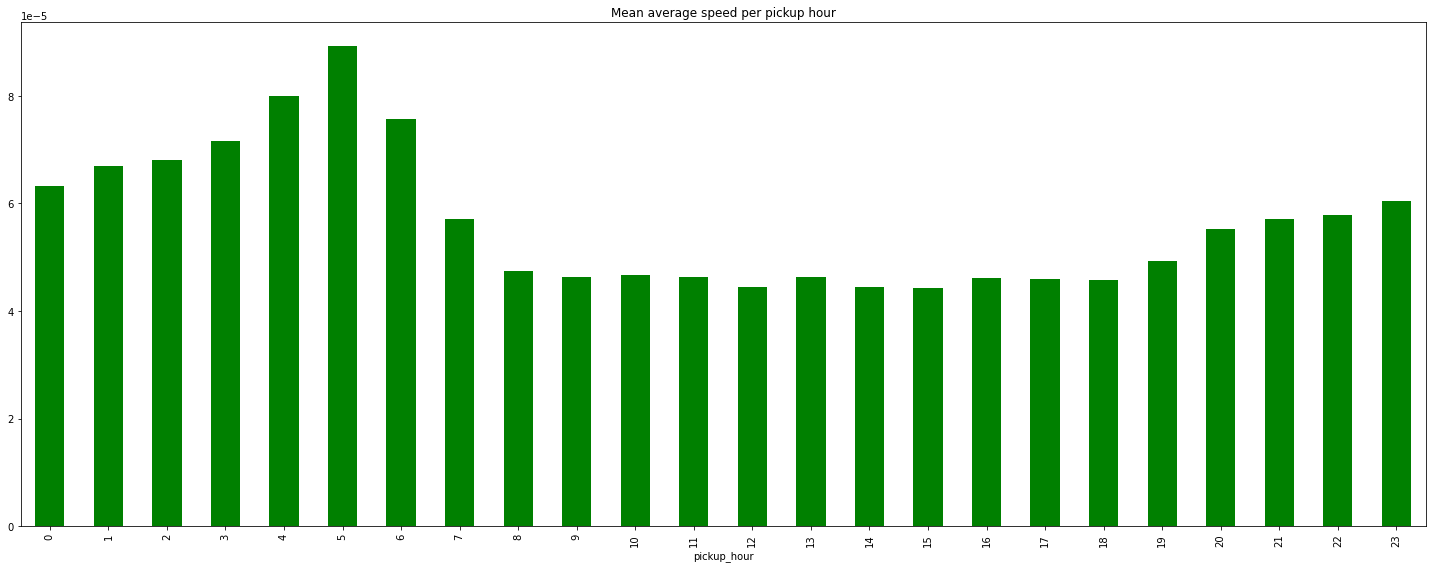

In [ ]:
plot_hist_avg_speed(tempDf,"pickup_hour","green","Mean average speed per pickup hour")

Εδώ, στο επόμενο ιστόγραμμα, παρουσιάζεται ένα ιστόγραμμα με τη μέση ταχύτητα των διαδρομών ανά ημέρα της εβδομάδας. Παρατηρούμε εδώ ότι την Κυριακή η μέση ταχύτητα είναι μεγαλύτερη από όλες τις ημέρες της εβδομάδας. Αυτό μπορεί να εξηγηθεί από το γεγονός ότι λιγότερα άτομα εργάζονται την Κυριακή και συνεπώς η κυκλοφοριακή συμφόρηση είναι μικρότερη εκείνη τη μέρα.


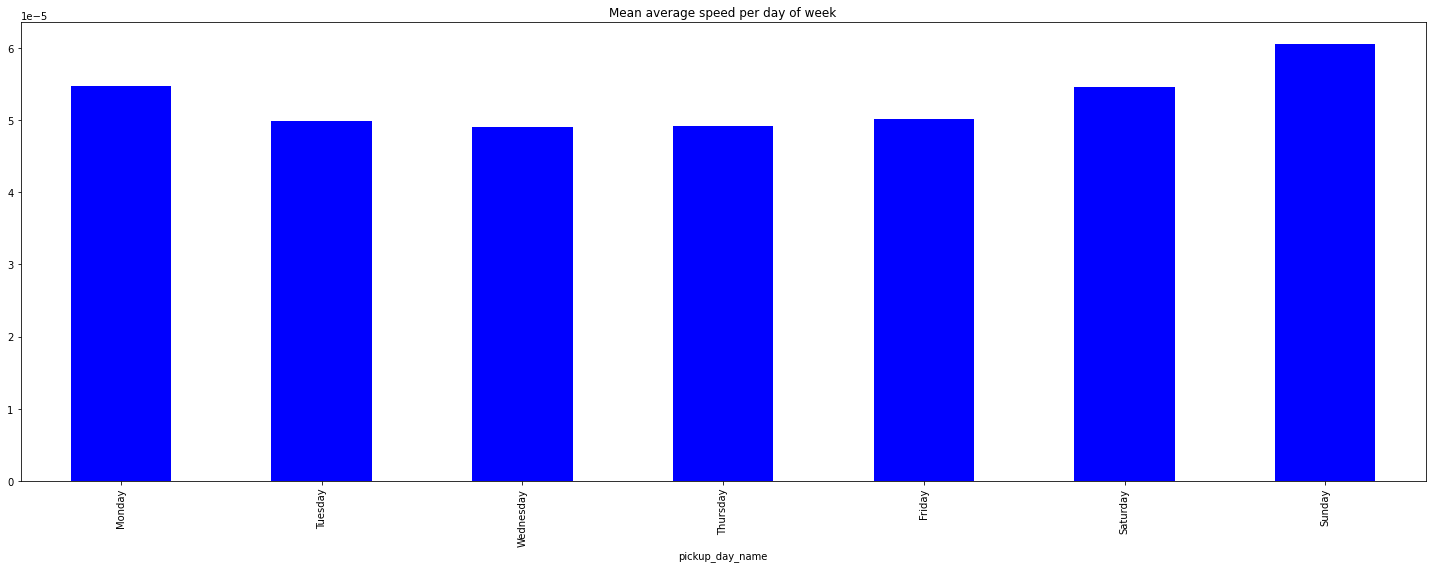

In [ ]:
plot_hist_avg_speed(tempDf,"pickup_day_name","blue","Mean average speed per day of week",sort_key=lambda x: x.map(day_of_week_dict))

Τέλος, παρακάτω παρουσιάζεται ένα ιστόγραμμα με τη μέση ταχύτητα των διαδρομών ανά μήνα. Εδώ δεν παρατηρούμε σημαντικές διαφορές μεταξύ των μηνών.


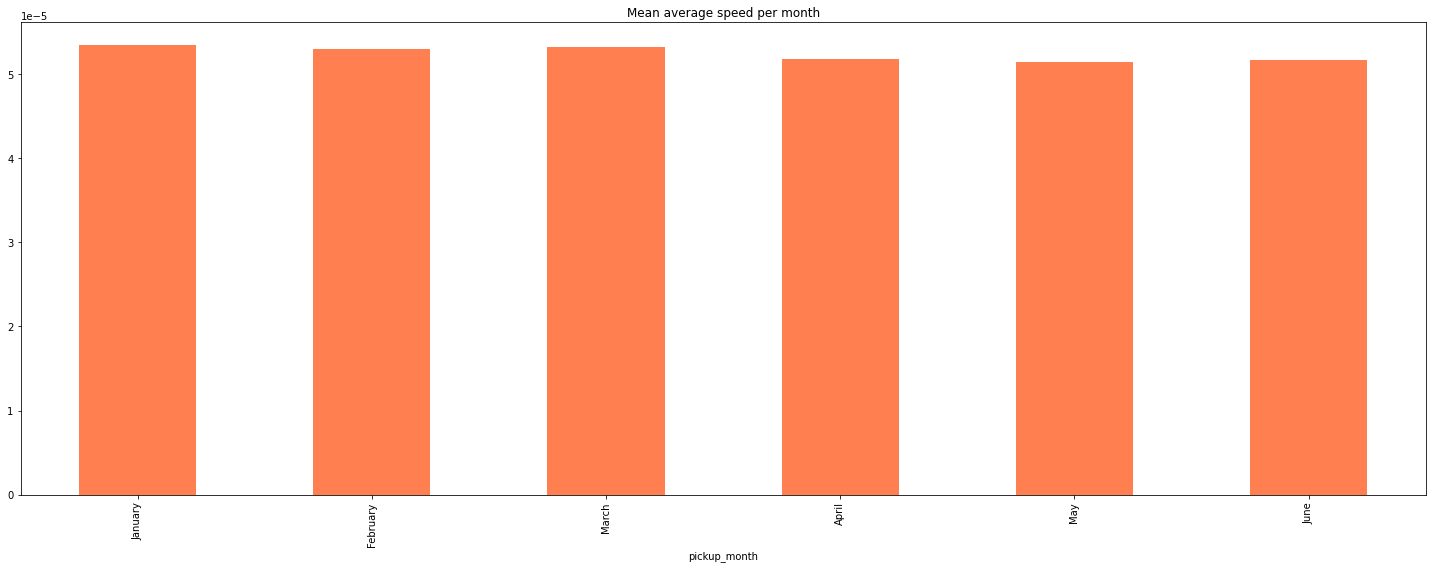

In [ ]:
plot_hist_avg_speed(tempDf,"pickup_month","coral","Mean average speed per month",sort_key=lambda x: x.map(month_dict))

# 9)

Τώρα δημιουργούμε 2 scatter plots με το πρώτο να περιέχει τα pickup σημεία των δεδομένων και το δεύτερο τα dropoff σημεία.

In [ ]:
def plotScatter(df,title_name,point_name):
  plt.title(title_name)
  plt.xlabel("Longitude")
  plt.ylabel("Latitude")
  plt.scatter(df[point_name+"_longitude"],df[point_name+"_latitude"],s=0.2)
  plt.show()

Εδώ φαίνονται τα pickup σημεία.

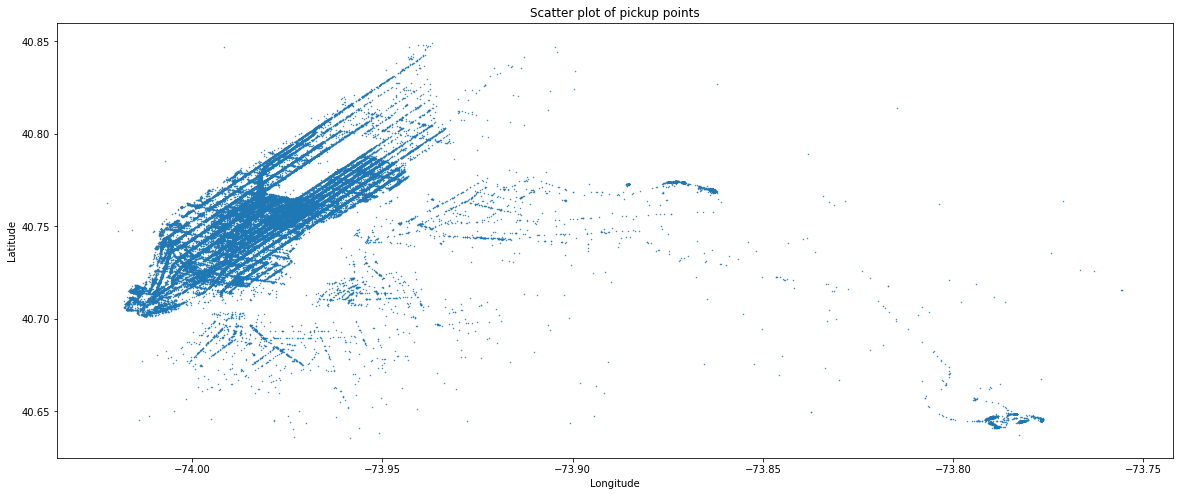

In [ ]:
plotScatter(df_train,"Scatter plot of pickup points","pickup")

Εδώ φαίνονται τα dropoff σημεία.

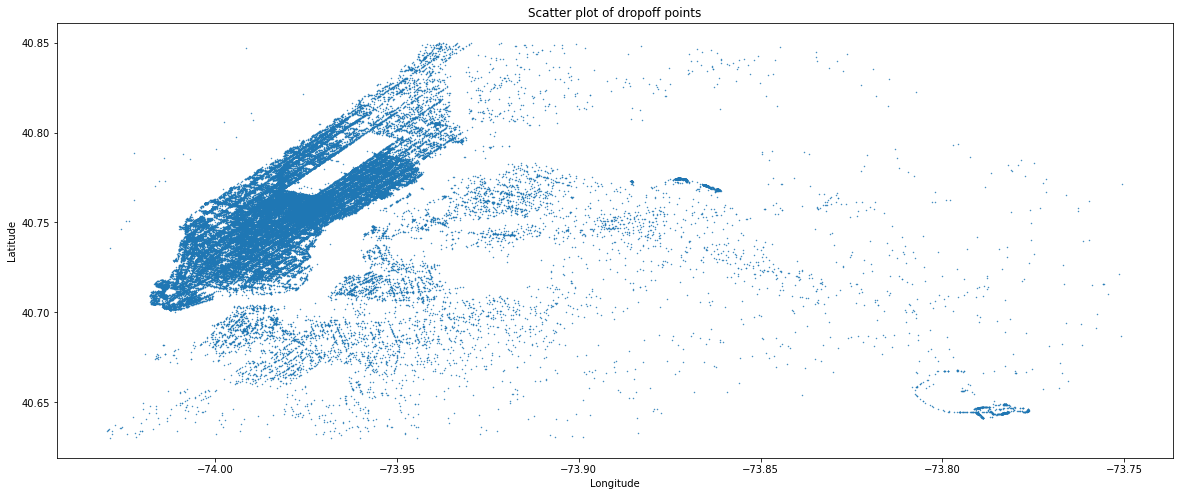

In [ ]:
plotScatter(df_train,"Scatter plot of dropoff points","dropoff")

Ένα συμπέρασμα που βγαίνει από τα παραπάνω δύο scatter plots είναι ότι τα dropoff σημεία είναι πιο διασκορπισμένα από τα pickup σημεία. Αυτό εξηγείται από το γεγονός ότι οι περισσότερες διαδρομές ξεκινούν συνήθως από πιο κεντρικούς δρόμους, ώστε ο επιβάτης να μπορέσει να βρει ευκολότερα κάποιο πάροχο για τη διαδρομή. Αντίθετα, τα dropoff σημεία είναι συνήθως ακριβώς στον προορισμό των επιβατών, ο οποίος μπορεί να βρίσκεται οπουδήποτε.





#Συσταδοποίηση και πρόβλεψη διάρκειας ταξιδιού

# 1)

Σε αυτό το ερώτημα κάνουμε συσταδοποίηση με τον kmeans. Αρχικά θα κάνουμε scale τα δεδομένα χρησημοποιώντας τον StandardScaler.

In [ ]:
from sklearn.preprocessing import StandardScaler 

sc=StandardScaler()
pickPointsTrain=df_train[["pickup_longitude","pickup_latitude"]].to_numpy()
pickPointsTest=df_test[["pickup_longitude","pickup_latitude"]].to_numpy()

scaledTrainSet=sc.fit_transform(pickPointsTrain)
scaledTestSet=sc.transform(pickPointsTest)

Θα χρησιμοποιήσουμε τώρα τη μέθοδο elbow για να υπολογίσουμε το βέλτιστο αριθμό από clusters. Όπως παρατηρούμε από το παρακάτω διάγραμμα ο αγκώνας βρίσκεται όταν ο αριθμός των clusters είναι 3. Οπότε θα χρησιμοποιήσουμε 3 clusters.

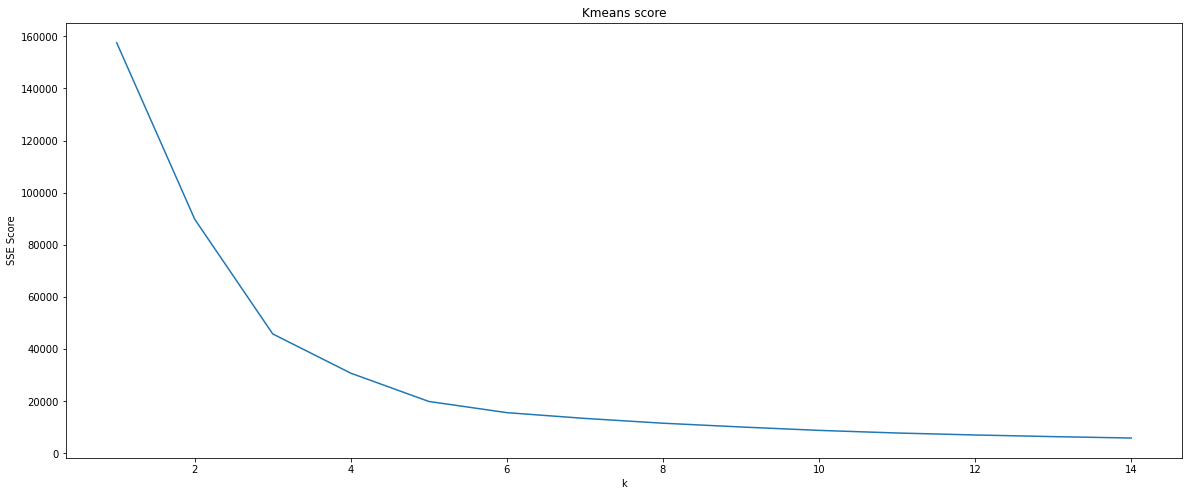

In [ ]:
from sklearn.cluster import KMeans 

def trainKMeansModel(k,scaledTrainSet):
  kmeans_model=KMeans(k)
  kmeans_model.fit(scaledTrainSet)

  return kmeans_model

list_score=[]

for k in range(1,15):
  kmeans_model=trainKMeansModel(k,scaledTrainSet)
  k_score=kmeans_model.inertia_
  list_score.append(k_score)

plt.plot(list(range(1,15)),list_score)
plt.title("Kmeans score")
plt.xlabel("k")
plt.ylabel("SSE Score")
plt.show()


Τώρα μπορούμε να εκπαιδεύσουμε τον K-means για αυτό τον αριθμό clusters που επιλέξαμε. Στη συνέχεια απεικονίζουμε με scatter plot τα clusters και τα κεντροειδή που βρήκαμε. Τα σημεία κάθε cluster απεικονίζονται με διαφορετικό χρώμα και τα κεντροειδή απεικονίζονται με μαύρο "x".

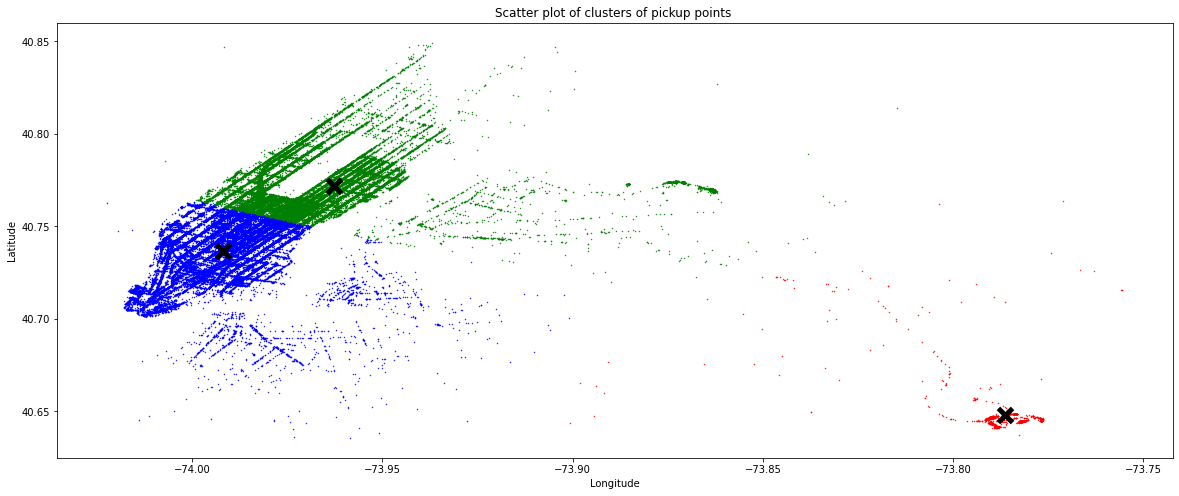

In [ ]:
k_best=3
colors=["blue","red","green","purple","brown","orange","gray","yellow"]

kmeans_model=trainKMeansModel(k_best,scaledTrainSet) 
clusters_ind=kmeans_model.predict(scaledTrainSet)
centroids=sc.inverse_transform(kmeans_model.cluster_centers_)

#Plot each cluster
for i in range(k_best):
  indices=np.where(clusters_ind==i)[0]
  plt.scatter(df_train["pickup_longitude"][indices],df_train["pickup_latitude"][indices],s=0.2,color=colors[i])
  plt.scatter([centroids[i][0]],[centroids[i][1]],marker="x",color="black",s=200,linewidth=5)

plt.title("Scatter plot of clusters of pickup points ")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Βλέπουμε από το παραπάνω scatter plot ότι τα 3 clusters που δημιουργήθηκαν φαίνονται οπτικά λογικά.

# 2)

Σε αυτό το ερώτημα θα γίνει πρόβλεψη της διάρκειας του ταξιδιού με τον RandomForestRegressor. Θα εκπαιδεύσουμε αρχικά το μοντέλο στο train set χρησιμοποιώντας τα προτεινόμενα χαρακατηριστικά και στη συνέχεια με το μοντέλο αυτό θα γίνει πρόβλεψη στο test set. Η σύγκριση και η μέτρηση της απόδοσης με τους πραγματικούς χρόνους στο test set για το μοντέλο αυτό θα γίνει στο ερώτημα 5).



In [ ]:
from sklearn.ensemble import RandomForestRegressor

season_dict={'Winter': 0, 
            'Spring': 1, 
            'Summer': 2, 
            'Autumn': 3}

feature_names=["vendor_id","passenger_count","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude",
                 "pickup_day_name","pickup_month","pickup_season","pickup_day_period","pickup_hour","manhattan_distance"]

#Transform the strings(etc Monday) to numbers
df_train_with_num=df_train[feature_names].copy()
df_train_with_num=df_train_with_num.replace({"pickup_day_name":day_of_week_dict})
df_train_with_num=df_train_with_num.replace({"pickup_month":month_dict})
df_train_with_num=df_train_with_num.replace({"pickup_season":season_dict})
df_train_with_num=df_train_with_num.replace({"pickup_day_period":day_dict})


df_test_with_num=df_test[feature_names].copy()
df_test_with_num=df_test_with_num.replace({"pickup_day_name":day_of_week_dict})
df_test_with_num=df_test_with_num.replace({"pickup_month":month_dict})
df_test_with_num=df_test_with_num.replace({"pickup_season":season_dict})
df_test_with_num=df_test_with_num.replace({"pickup_day_period":day_dict})


#Create the X,Y for the classifier
xtrain=df_train_with_num[feature_names].to_numpy()
xtest=df_test_with_num[feature_names].to_numpy()

ytrain=df_train["log_trip_duration"].to_numpy()

ytest=np.log(df_target["trip_duration"]).to_numpy() #This is for checking later the efficiency of the model in the test set

rfr_clf=RandomForestRegressor(max_depth=7,n_estimators=50)

rfr_clf.fit(xtrain,ytrain)

predicted_log_trip_dur=rfr_clf.predict(xtest)

print("Predicted log trip duration values:")
print(predicted_log_trip_dur)


Predicted log trip duration values:
[5.91433387 6.53522037 6.98299851 ... 7.27245172 6.16385704 7.6057545 ]


Στο παρακάτω ιστόγραμμα απεικονίζουμε τα πιο σημαντικά χαρακτηριστικά, όπως τα εκτίμησε το μοντέλο μας. Όπως βλέπουμε και είναι λογικό, με μεγάλη διαφορά το σημαντικότερο χαρακτηριστικό είναι η απόσταση manhattan. Η dropoff_latitude μαζί με την ώρα εκκίνησης του ταξιδιού είναι επίσης σημαντικά χαρακτηριστικά.

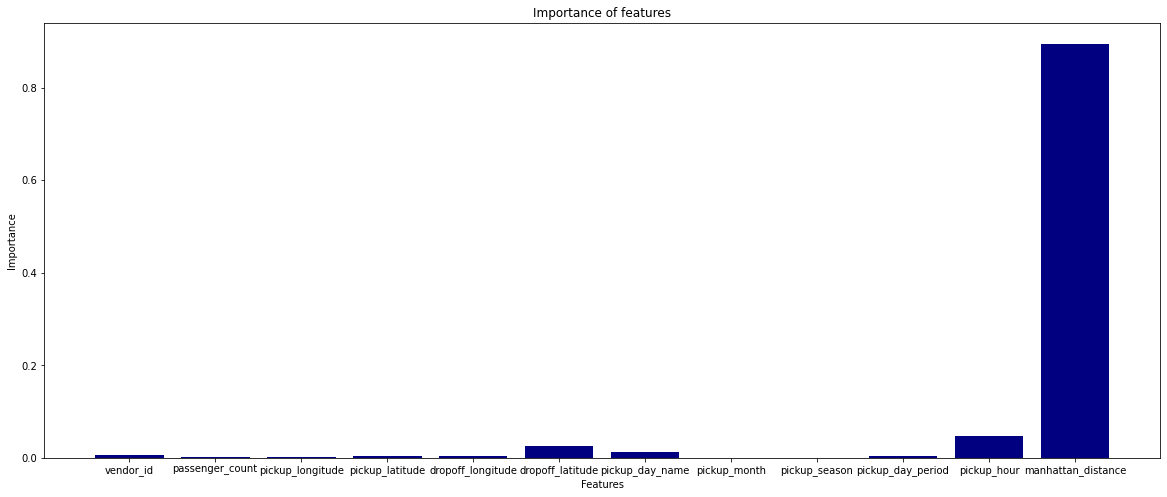

In [ ]:
plt.title("Importance of features")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.bar(feature_names,rfr_clf.feature_importances_,color="navy")
plt.show()


# 3)
Τώρα, χρησιμοποιώντας την GridSearchCV, θα βρούμε τις καλύτερες παραμέτρους για τον RandomForestRegressor. Επιλέγουμε μερικές τιμές για τις παραμέτρους max_depth, max_features, n_estimators και η GridSearchCV βρίσκει ποιες είναι οι καλύτερες από αυτές.

In [ ]:
from sklearn.model_selection import GridSearchCV

rfr=RandomForestRegressor()
parameters={"max_depth":[3,7,10],"max_features":[0.2,0.5,1.0],"n_estimators":[10,50,100,200]}
clf=GridSearchCV(rfr,parameters)
clf.fit(xtrain,ytrain)

print("Best parameters found:")
print(clf.best_params_)

Best parameters found:
{'max_depth': 10, 'max_features': 1.0, 'n_estimators': 200}


Όπως βλέπουμε οι καλύτερες παράμετροι είναι το 10 για το max_depth, το 1.0 για το max_features και το 200 για το n_estimators.

#4)
Τώρα για τις καλύτερες παραμέτρους που βρήκαμε παραπάνω εκπαιδεύουμε ξανά το μοντέλο μας.

In [ ]:
rfr_clf_best=RandomForestRegressor(max_depth=10,max_features=1.0,n_estimators=200)

rfr_clf_best.fit(xtrain,ytrain)

#5)
Τώρα, με το καλύτερο μοντέλο που βρήκαμε προβλέπουμε το λογάριθμο του χρόνου ταξιδιού στο test dataset.

In [ ]:
best_predicted_log_trip_dur=rfr_clf_best.predict(xtest)

print("Predicted log trip duration values:")
print(best_predicted_log_trip_dur)

Predicted log trip duration values:
[5.82215416 6.66134265 6.95740597 ... 7.1207641  6.03045437 7.64439065]


Μετράμε τώρα την απόδοση του μοντέλου χρησημοποιώντας τις μετρικές MAE,MSE. Στο παρακάτω πινακάκι παρουσιάζεται με τις δύο αυτές μετρικές τόσο η απόδοση του αρχικού μοντέλου, όσο και η απόδοση του μοντέλου με τις καλύτερες παραμέτρους που βρήκαμε για να γίνει η σύγκριση.

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
from tabulate import tabulate

mae_init=mean_absolute_error(ytest,predicted_log_trip_dur)
mae_best=mean_absolute_error(ytest,best_predicted_log_trip_dur)
mse_init=mean_squared_error(ytest,predicted_log_trip_dur)
mse_best=mean_squared_error(ytest,best_predicted_log_trip_dur)


table=[["MAE","MSE"],[mae_init,mse_init],[mae_best,mse_best]]
print(tabulate(table,headers="firstrow", tablefmt="fancy_grid",showindex=["Initial Model","Model with best parameters"]))

╒════════════════════════════╤═════════╤══════════╕
│                            │     MAE │      MSE │
╞════════════════════════════╪═════════╪══════════╡
│ Initial Model              │ 0.32645 │ 0.225729 │
├────────────────────────────┼─────────┼──────────┤
│ Model with best parameters │ 0.30785 │ 0.209289 │
╘════════════════════════════╧═════════╧══════════╛


Παρατηρούμε ότι και τα δύο είδη errors στο μοντέλο με τις καλύτερες παραμέτρους είναι μικρότερα από ότι αυτά στο αρχικό μας μοντέλο. Επομένως το νέο μοντέλο είναι πράγματι βελτιωμένο.

#Bonus


#1) 
Θα χρησιμοποίησουμε τώρα τη βιβλιοθήκη folium για να αναπαραστήσουμε τα dropoff σημεία του train dataset στο χάρτη της Νέας Υόρκης. Θα χρησιμοποιηθούν 5000 σημεία για γρηγορότερα και περισσότερο ευκρινή αποτελέσματα.

In [ ]:
import folium

m = folium.Map(location=[(40.63+40.85)/2,(-74.03-73.75)/2], zoom_start=12)

for index, row in df_train.iloc[:5000,:].iterrows():
  folium.Marker([row["dropoff_latitude"],row["dropoff_longitude"]]).add_to(m)

display(m)

# 2)

#a)

Εδώ θα αναλύσουμε περισσότερο κάποια από τα δεδομένα μας. 

Παρακάτω φτιάχνουμε ένα ιστόγραμμα όπου φαίνεται ο αριθμός των ταξιδιών ανά vendor_id. 

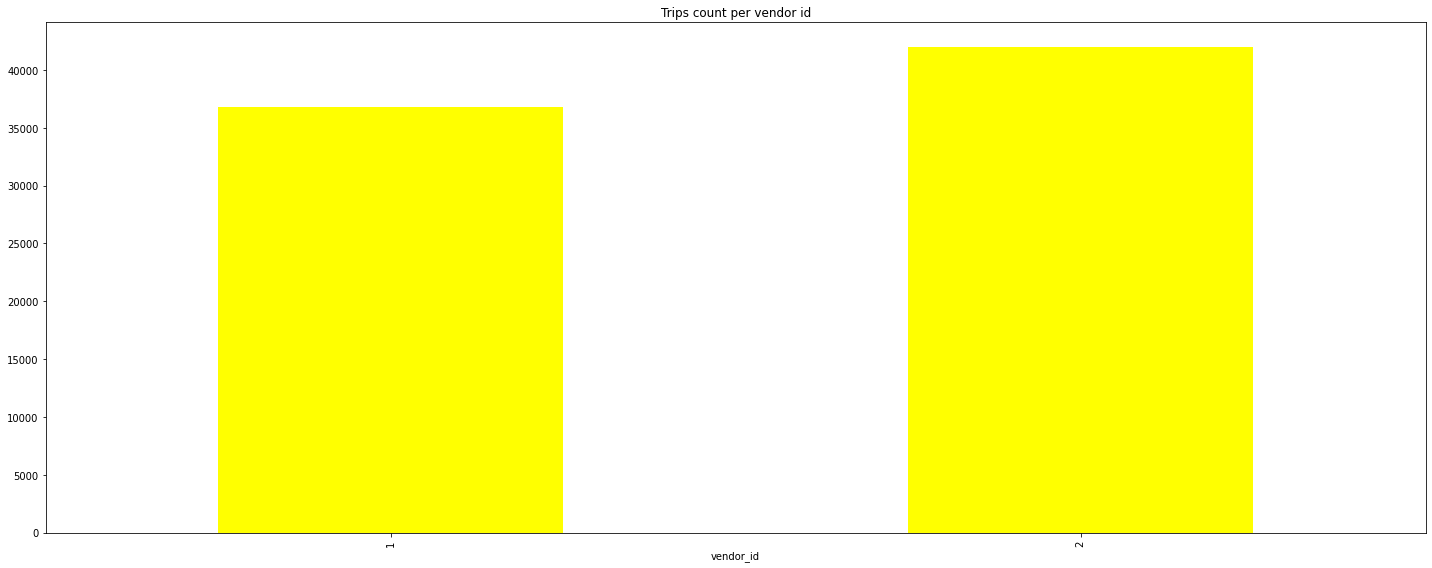

In [ ]:
plot_hist(df_train,"vendor_id","yellow","Trips count per vendor id",lambda x: x)

Παρατηρούμε ότι ο πάροχος με id 2 έχει αναλάβει τις περισσότερες διαδρομές. 

Συμπεράσματα για την κυκλοφοριακή συμφόρηση που προτείνεται στην εκφώνηση έχουν ήδη γίνει παραπάνω στο ερώτημα 8) στην ανάλυση δεδομένων.

# b)

Τώρα θα προσθέσουμε μερικά επιπλέον features στα δεδομένα μας και θα εξετάσουμε αν τα νέα μοντέλα που εκπαιδεύουμε δίνουν καλύτερα αποτελέσματα. Στα νέα μοντέλα χρησιμοποιούνται οι καλύτερες παράμετροι που έχουμε επιλέξει παραπάνω. Στο τέλος του ερωτήματος, παρουσιάζεται ένα πινακάκι με τα errors των διάφορων μοντέλων με τα επιπλέον features και αναλύεται αν βελτιώνουν αυτά τα features το μοντέλο.

Αρχικά, προσθέτουμε ένα feature για το αν η διαδρομή έγινε Σαββατοκύριακο ή όχι. Έπειτα εκπαιδεύουμε το νέο μοντέλο και κάνουμε πρόβλεψη στο test dataset.


In [ ]:
def is_weekend(day):
  if day>=5:
    return 1
  else:
    return 0

df_train_with_num["is_weekend"]=df_train_with_num["pickup_day_name"].apply(is_weekend)
df_test_with_num["is_weekend"]=df_test_with_num["pickup_day_name"].apply(is_weekend)

rfr_clf_weekend=RandomForestRegressor(max_depth=10,max_features=1.0,n_estimators=200)

xtrain_weekend=df_train_with_num.to_numpy()
xtest_weekend=df_test_with_num.to_numpy()

rfr_clf_weekend.fit(xtrain_weekend,ytrain)

weekend_predicted_log_trip_dur=rfr_clf_weekend.predict(xtest_weekend)

print("Predicted log trip duration values:")
print(weekend_predicted_log_trip_dur)

Predicted log trip duration values:
[5.81059365 6.65943493 6.95334048 ... 7.1236229  6.02460587 7.65095711]


Τώρα, προσθέτουμε ένα feature για το αν η έναρξη της διαδρομής έγινε κατά τη διάρκεια της μέρας(7πμ-7μμ) ή κατά τη διάρκεια της νύχτας(7μμ-7πμ). Έπειτα εκπαιδεύουμε πάλι το νέο μοντέλο και κάνουμε πρόβλεψη στο test dataset.

In [ ]:
def day_or_night(hour):
  if hour>18 or hour<=6:
    return 0
  else:
    return 1

df_train_with_num["is_day"]=df_train_with_num["pickup_hour"].apply(day_or_night)
df_test_with_num["is_day"]=df_test_with_num["pickup_hour"].apply(day_or_night)

rfr_clf_day=RandomForestRegressor(max_depth=10,max_features=1.0,n_estimators=200)

xtrain_day=df_train_with_num.to_numpy()
xtest_day=df_test_with_num.to_numpy()

rfr_clf_day.fit(xtrain_day,ytrain)

day_predicted_log_trip_dur=rfr_clf_day.predict(xtest_day)

print("Predicted log trip duration values:")
print(day_predicted_log_trip_dur)

Predicted log trip duration values:
[5.8411422  6.66709306 6.94946001 ... 7.11810593 5.94803508 7.62504005]


Συγκρίνουμε τώρα την απόδοση από τα τρία μοντέλα μας: Αυτό που εκπαιδεύτηκε με τα αρχικά features, αυτό που εκπαιδεύτηκε επιπλέον με το feature σχετικά με το αν είναι Σαβββατοκύριακο και αυτό που εκπαιδεύτηκε επιπλέον με το feature σχετικά με το αν είναι μέρα ή νύχτα. Παρακάτω φαίνεται ο πίνακας με τα errors στις προβλέψεις(MAE και MSE) στο test dataset για τα τρία μοντέλα.

In [ ]:
mae_weekend=mean_absolute_error(ytest,weekend_predicted_log_trip_dur)
mae_day=mean_absolute_error(ytest,day_predicted_log_trip_dur)
mse_weekend=mean_squared_error(ytest,weekend_predicted_log_trip_dur)
mse_day=mean_squared_error(ytest,day_predicted_log_trip_dur)


table=[["MAE","MSE"],[mae_best,mse_best],[mae_weekend,mse_weekend],[mae_day,mse_day]]
print(tabulate(table,headers="firstrow", tablefmt="fancy_grid",showindex=["No extra feature","Is_weekend extra feature","Is_day_or_night extra feature"]))



╒═══════════════════════════════╤══════════╤══════════╕
│                               │      MAE │      MSE │
╞═══════════════════════════════╪══════════╪══════════╡
│ No extra feature              │ 0.30785  │ 0.209289 │
├───────────────────────────────┼──────────┼──────────┤
│ Is_weekend extra feature      │ 0.308107 │ 0.209641 │
├───────────────────────────────┼──────────┼──────────┤
│ Is_day_or_night extra feature │ 0.306709 │ 0.208143 │
╘═══════════════════════════════╧══════════╧══════════╛


Από το παραπάνω πινακάκι διαπιστώνουμε ότι κανένα από τα επιπλέον χαρακτηριστικά δεν βελτίωσε το μοντέλο, αφού οι διαφορές στα errors είναι αμελητέες. Συνεπώς, το μοντέλο που είχαμε ήδη εκπαιδεύσει με τα αρχικά χαρακτηριστικά και τις καλύτερες παραμέτρους είναι αυτό που είναι πιο χρήσιμο για τις προβλέψεις.